In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.get_device_name(0))

False
0


In [3]:
# data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

The dataloader is compoosed of 12 batches, each of them of size 15 making a total of: 180, which is enough for storing the 179 images that we have in the positive dataset

In [5]:
print(len(dataloader))

12


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\Alex\.conda\envs\tfm\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0070) tensor(1.)


In [7]:
for i, (_data, _) in enumerate(dataloader):
    if(i==9):
        break
    print(i)

0
1
2
3
4
5
6
7
8


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

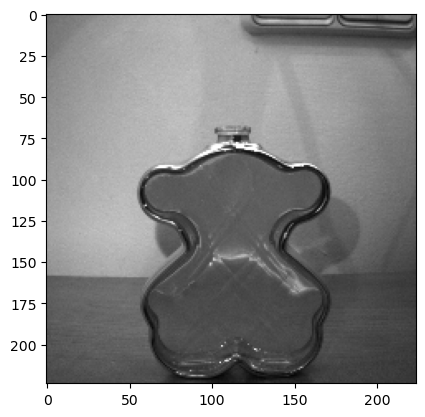

In [8]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 1, 224, 224.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter). Dimension rseult: -> 15, 110, 44, 44. Batch size, channel output, output image shape.
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # Dimension rseult: -> 15, 450, 1, 1
        )
        
        # Initial dimension for this part of the model: 15 , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 110, 44, 44
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 1, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cpu


In [11]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [12]:
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [13]:
# torch.cuda.empty_cache()

In [14]:
# # Point to training loop video
# num_epochs = 300
# outputs = []
# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs.append((epoch, img, recon))

Saving and loading a model

In [15]:
filepath = "../../models/pytorchModels/PytorchModel_withCUDA"


In [16]:
# torch.save(model.state_dict(), filepath)

In [16]:
# For loading the model 
# model.load_state_dict(torch.load(filepath)) # For home laptop
model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu'))) # For work laptop
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [17]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Original Images


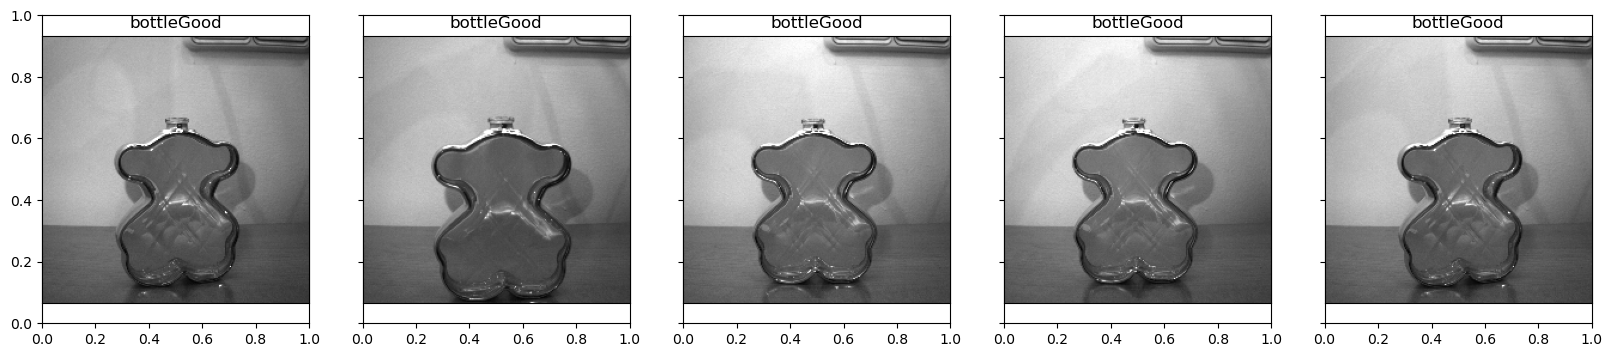

Reconstructed Images


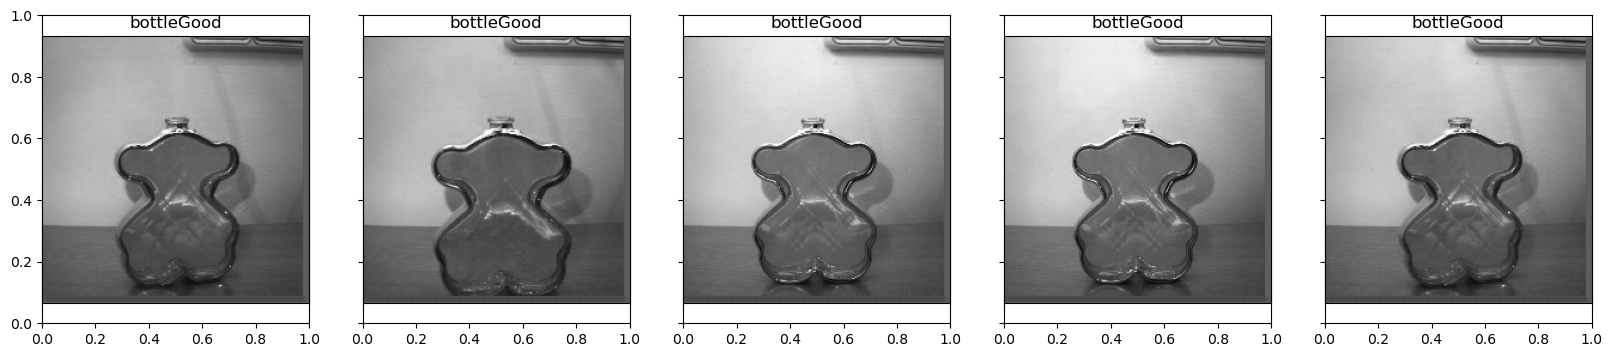

In [18]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)
images, labels = images, labels # add this line for displaying the image 
# images, labels = images.cuda(), labels.cuda() # add this line for displaying the image. For home laptop

#Sample outputs
output = model(images)

images = images.cpu().numpy()

# output = output.view(32, 3, 224, 224)
output = output.view(15, 3, 224, 224)       # Because the batch size was changed to 15
output = output.cpu().detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
# plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

Performing the computation of the reconstruction error of all the images in the dataset. Additionally, consider the mean reconstruction error, rather than the direct sum of these.

In [19]:
X = dataset[0]
image_in_tensor = X[0]
result_lst = []
n_features = len(image_in_tensor[0])  # 65
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    # image_in_tensor = image_in_tensor.cuda()   # If using the GPU
    image_in_tensor = image_in_tensor            # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.49177306038992746), (1, 0.28578685578845797), (2, 0.31931211834862117), (3, 0.2718916620526995), (4, 0.2625248772757394), (5, 0.2506704784574963), (6, 0.31626033782958984), (7, 0.31497918991815477), (8, 0.31570954549880254), (9, 0.31370853242420016), (10, 0.21464758827572777), (11, 0.20509061359223865), (12, 0.28391586031232563), (13, 0.28200303940545945), (14, 0.2685162680489676), (15, 0.2405573527018229), (16, 0.22900610878354027), (17, 0.24354312533424013), (18, 0.24118144171578543), (19, 0.36257164818899973), (20, 0.22534978957403273), (21, 0.2216364996773856), (22, 0.17322937647501627), (23, 0.15739826929001582), (24, 0.13969196592058455), (25, 0.21366473606654576), (26, 0.19444867542811803), (27, 0.1969044322059268), (28, 0.19437803540910994), (29, 0.18114410127912248), (30, 0.17597298395066036), (31, 0.19980203537713914), (32, 0.1704556487855457), (33, 0.16867058617728098), (34, 0.18005525498163133), (35, 0.15596984681629), (36, 0.16269927933102563), (37, 0.18511660893758

In [20]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(0, 0.49177306038992746), (175, 0.43966892787388395), (176, 0.3937140873500279), (178, 0.388476326352074), (177, 0.37863229569934664), (19, 0.36257164818899973), (155, 0.3498460678827195), (166, 0.3442799477350144), (2, 0.31931211834862117), (6, 0.31626033782958984), (8, 0.31570954549880254), (7, 0.31497918991815477), (9, 0.31370853242420016), (102, 0.2907728240603492), (1, 0.28578685578845797), (12, 0.28391586031232563), (13, 0.28200303940545945), (51, 0.28096026466006324), (3, 0.2718916620526995), (14, 0.2685162680489676), (4, 0.2625248772757394), (5, 0.2506704784574963), (120, 0.2436872891017369), (17, 0.24354312533424013), (18, 0.24118144171578543), (167, 0.2406017439705985), (15, 0.2405573527018229), (156, 0.24000942139398485), (165, 0.23339348747616723), (39, 0.23293495178222656), (163, 0.23157246907552084), (164, 0.2300997915722075), (168, 0.2296373957679385), (16, 0.22900610878354027), (100, 0.2267446063813709), (172, 0.22672884804861887), (173, 0.22623368671962193), (162, 0.2

Gaphically the distribution of the reconstruction error values is shown below:

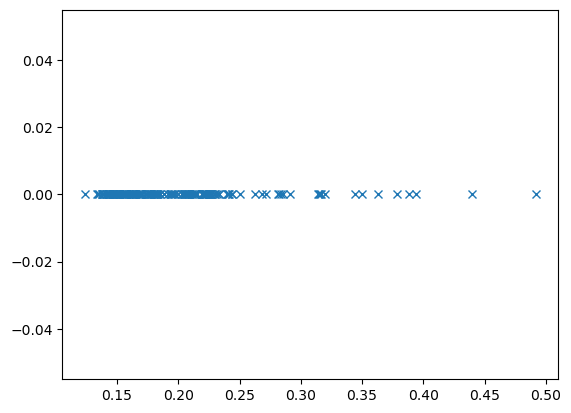

In [21]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [22]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.19925843416677252
The standard deviation of the errors list is:  0.06031440879328735
The min value of the errors list is:  0.12373622258504231
The max value of the errors list is:  0.49177306038992746


## Checking the MSE reconstruction error of the anomaly images

We first load the anomaly images dataset

In [23]:
# data_anomalies = '../../../Images/BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
data_anomalies = '../../../../BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset_anomalies = datasets.ImageFolder(data_anomalies, transform=transform_characteristics)
dataloader_anomalies = torch.utils.data.DataLoader(dataset_anomalies, batch_size=32, shuffle=True)

In [24]:
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_anomalies[0]
image_in_tensor = X[0]
# image_in_tensor = image_in_tensor.cuda()            # If using the GPU
image_in_tensor = image_in_tensor            # If NO GPU
n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_anomalies)):
    X = dataset_anomalies[i]
    image_in_tensor = X[0]
    # image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    image_in_tensor = image_in_tensor            # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.3353566669282459), (1, 0.21508702777680896), (2, 0.26451362882341656), (3, 0.4930871781848726), (4, 0.2715788795834496), (5, 0.20387329374040877)]


In [25]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(3, 0.4930871781848726), (0, 0.3353566669282459), (4, 0.2715788795834496), (2, 0.26451362882341656), (1, 0.21508702777680896), (5, 0.20387329374040877)]


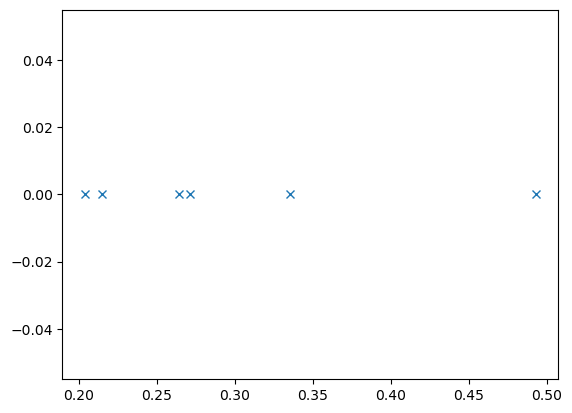

In [26]:
errors_list_anomalies = []
for i in range(len(result_lst)):
    errors_list_anomalies.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [27]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.2972494458395337
The standard deviation of the errors list is:  0.09747218245875945
The min value of the errors list is:  0.20387329374040877
The max value of the errors list is:  0.4930871781848726


## Comparing the reconstruction error of anomaly and normal images

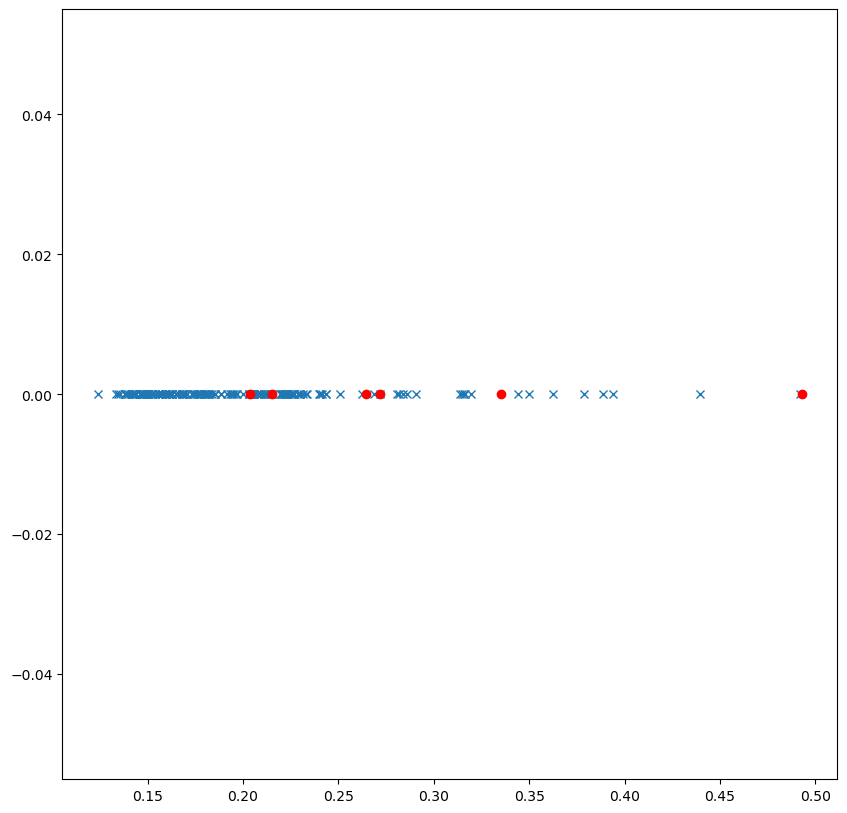

In [28]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

Above see that the reconstruction error between normal and anomaly images are NOT clearly divided in the plot. This could be a problem for the overall detection.

# Coding a function to check if an image contains anomalies

We know that for the non-anomaly images, the mean and std devation is:

In [29]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.19925843416677252
The standard deviation of the errors list is:  0.06031440879328735
The min value of the errors list is:  0.12373622258504231
The max value of the errors list is:  0.49177306038992746


And for the anomaly image, the std deviation and mean values are:

In [30]:
a_avg_rcn_error = np.mean(np.array(errors_list_anomalies))  
a_stdev_rcn_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE TRAINING ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_avg_rcn_error)
print("The standard deviation of the errors list is: ", a_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING ANOMALY IMAGES

The average of the errors list is:  0.2972494458395337
The standard deviation of the errors list is:  0.09747218245875945
The min value of the errors list is:  0.20387329374040877
The max value of the errors list is:  0.4930871781848726


According to this, we will work with the following:

- The error value is 0.199258. This is exactly the average of the non-anomaly distribution, then it should have a 0% probability of being detected as an anomaly image.
- The error value is 0.199258 +/- 0.0603144. Then the probability of being detected as an anomaly bottle is 50%. And, as typically, we decide that a value higher than 50% is considered as an anomaly image, then every value higher or lower than this quantity will be considered as an anomaly image.

In [31]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [32]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [33]:
print(map_error2prob(na_avg_rcn_error + na_stdev_rcn_error))

50.000000000000014


In [34]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

Checking the probability of being detected as anomaly images of the set of non-anomaly images. Ideally, all these images should output a probability of around 0%, because these are not anomaly images.

Moreover, we decide whether an image is anomaly or not, based on its reconstruction error.

In [35]:
print("Considering the non-anomaly dataset. The number of images to be cheked is: ", len(errors_list))
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

Considering the non-anomaly dataset. The number of images to be cheked is:  179
The prediction probabilities list for the non-anomaly images is: 
[1.         1.         1.         1.         1.         1.
 1.         1.         0.99523221 0.96993327 0.96536726 0.95931269
 0.94877908 0.75864451 0.71731136 0.70180101 0.68594393 0.67729944
 0.60212169 0.57414004 0.52447205 0.42620035 0.36831046 0.36711535
 0.34753725 0.34273162 0.34236362 0.33782133 0.28297594 0.27917473
 0.26787989 0.25567156 0.25183834 0.24660504 0.22785743 0.22772679
 0.22362196 0.2233174  0.21629455 0.21472693 0.20767246 0.20052499
 0.192247   0.19171467 0.19078611 0.18968418 0.18639384 0.18551177
 0.17932995 0.17404075 0.17404075 0.1696801  0.16650816 0.13227335
 0.12757444 0.12256269 0.1194267  0.11076075 0.11076075 0.10051834
 0.09582809 0.08539612 0.07862344 0.07307974 0.07269593 0.06613256
 0.06613256 0.05586097 0.05478182 0.04834814 0.04676998 0.04676998
 0.04359898 0.03164947 0.03132533 0.0045064  0.01951442 0.

Let's now check the reconstruction error of the anomaly images.

In [36]:
print("Considering the anomaly dataset. The number of images to be cheked is: ", len(errors_list_anomalies))
preds_probs = np.array(map_error2prob_list(errors_list_anomalies))
preds_probs = preds_probs/100
print("The prediction probabilities list for the anomaly images is: ")
print(preds_probs)

Considering the anomaly dataset. The number of images to be cheked is:  6
The prediction probabilities list for the anomaly images is: 
[1.         1.         0.59952876 0.54095859 0.13121735 0.03825669]


See that for the classification of the anomaly images we have:
- Four samples that were correctly identified as anomaly images.
- Two samples that were classified as non-anomaly. These are false negatives.


# Evaluating the performance of the model

So far, it has been used two dataset for doing the above tests: The full non-anomalies dataset and a full anomalies dataset. We will create a third dataset with a mix of these two types of images.

In [37]:
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
classes = ('non-anomaly','anomaly')

In [38]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred


In [39]:
y_true = []
result_lst = []
# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    # image_in_tensor = image_in_tensor.cuda()   # If using the GPU
    image_in_tensor = image_in_tensor            # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print(result_lst)
print(y_true)

[0.38930420648484004, 0.399500983101981, 0.4123103732154483, 0.4126557849702381, 0.41613283611479257, 0.42479424249558223, 0.43302608671642484, 0.41800044831775485, 0.39871946970621747, 0.4163909639630999, 0.3813688187372117, 0.38856724330357145, 0.38334446861630395, 0.41080792744954425, 0.42530418577648343, 0.3876966748918806, 0.6965536844162714, 0.6218682243710473, 0.43417281196230934, 0.3911734081449963, 0.39085497174944195, 0.38057197843279156, 0.3804349899291992, 0.3828881581624349, 0.3886048907325381, 0.8127015431722006, 0.8090906597319103, 0.8426771618071056, 0.8498846689860026, 0.8575215112595331]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [40]:
print(type(result_lst))

<class 'list'>


In [41]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, result_lst))

AUC =  1.0


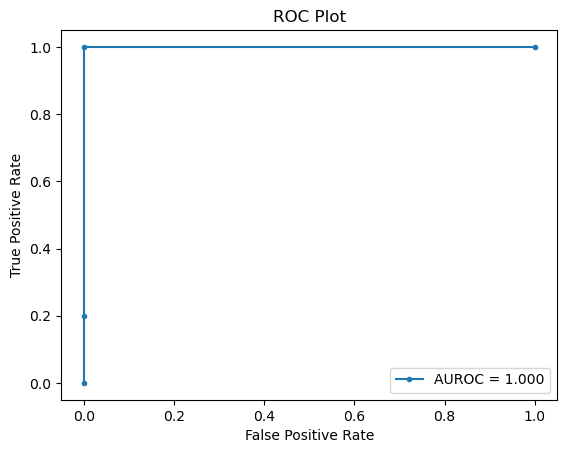

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, result_lst)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, result_lst))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [43]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0. 0. 0. 1.]
The tpr is:  [0.  0.2 1.  1. ]
The thresholds are:  [1.85752151 0.85752151 0.80909066 0.38043499]


Now, let's try to compute the AUC score with the probability score rather than directly the reconstruction error, which is stored in the "result_lst" variable

In [44]:
print(result_lst)

[0.38930420648484004, 0.399500983101981, 0.4123103732154483, 0.4126557849702381, 0.41613283611479257, 0.42479424249558223, 0.43302608671642484, 0.41800044831775485, 0.39871946970621747, 0.4163909639630999, 0.3813688187372117, 0.38856724330357145, 0.38334446861630395, 0.41080792744954425, 0.42530418577648343, 0.3876966748918806, 0.6965536844162714, 0.6218682243710473, 0.43417281196230934, 0.3911734081449963, 0.39085497174944195, 0.38057197843279156, 0.3804349899291992, 0.3828881581624349, 0.3886048907325381, 0.8127015431722006, 0.8090906597319103, 0.8426771618071056, 0.8498846689860026, 0.8575215112595331]


In [45]:
na_avg_rcn_error + na_stdev_rcn_error

0.2595728429600599

In [46]:
print(map_error2prob(0.38930420648484004))

100


In [47]:
preds_probs = np.array(map_error2prob_list(result_lst))
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

The prediction probabilities list for the non-anomaly images is: 
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100]


With the above result the AUC score is expected to be low.

AUC =  0.5


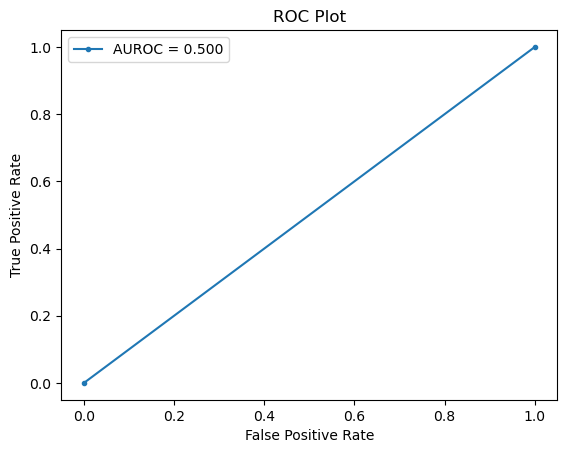

In [48]:
print('AUC = ', metrics.roc_auc_score(y_true, preds_probs))
fpr, tpr, thresholds = metrics.roc_curve(y_true, preds_probs)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, preds_probs))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [49]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0. 1.]
The tpr is:  [0. 1.]
The thresholds are:  [101 100]


What happens is that the average of the reconsturction error of the non-anomaly images in the training set is much lower than the average of the non-anomaly images of the test set. That is why all the probabilities of anomaly images output 100%, these don't even show a small chance of being detected as non-anomaly, all of them are 100%, this is why the AUC score is 0.5 and the ROC curve cannot find a threshold that make this behavior improve a little. 